<a href="https://colab.research.google.com/github/arumshin-dev/python_conda_jupyter/blob/main/codeit/3_3_1_BERT_%E1%84%89%E1%85%A1%E1%84%8C%E1%85%A5%E1%86%AB%E1%84%92%E1%85%A1%E1%86%A8%E1%84%89%E1%85%B3%E1%86%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 사전 학습을 위한 데이터세트 구성

BERT 모델은 사전학습과 미세조정(Fine-Tuning)이 확실하게 나눠지는 대표적인 모델입니다.  
미세조정은 자연어 Task에 따라 다양하게 진행 될 수 있지만, 사전 학습은 대부분 NSP 학습과 MLM 학습으로 진행이 됩니다.   

해당 예시에서는 [AIHUB](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=86) 한국어 감성 대화 말뭉치를 부분적으로 활용하여 질의->응답 으로 NSP와 MLM 사전 학습을 동시 진행해봅니다.

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving train.csv to train.csv


In [ ]:
import torch
from torch import nn
import copy
from torch.utils.data import Dataset, DataLoader, random_split
import sentencepiece as spm
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv(f'./train.csv')
df[['HS01','SS01']]

,HS01,SS01
0,일은 왜 해도 해도 끝이 없을까? 화가 난다.,많이 힘드시겠어요. 주위에 의논할 상대가 있나요?
1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,급여가 줄어 속상하시겠어요. 월급이 줄어든 것을 어떻게 보완하실 건가요?
2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,회사 동료 때문에 스트레스를 많이 받는 것 같아요. 문제 해결을 위해 어떤 노력을 ...
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,관련 없는 심부름을 모두 하게 되어서 노여우시군요. 어떤 것이 상황을 나아질 수 있...
4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,무시하는 것 같은 태도에 화가 나셨군요. 상대방의 어떤 행동이 그런 감정을 유발하는...
...,...,...
51623,나이가 먹고 이제 돈도 못 벌어 오니까 어떻게 살아가야 할지 막막해. 능력도 없고.,경제적인 문제 때문에 막막하시군요. 마음이 편치 않으시겠어요.
51624,몸이 많이 약해졌나 봐. 이제 전과 같이 일하지 못할 것 같아 너무 짜증 나.,건강에 대한 어려움 때문에 기분이 좋지 않으시군요. 속상하시겠어요.
51625,이제 어떻게 해야 할지 모르겠어. 남편도 그렇고 노후 준비도 안 되어서 미래가 걱정돼.,노후 준비에 대한 어려움 때문에 걱정이 많으시겠어요.
51626,몇십 년을 함께 살았던 남편과 이혼했어. 그동안의 세월에 배신감을 느끼고 너무 화가 나.,가족과의 문제 때문에 속상하시겠어요.


### NSP 학습을 위한 두문장 토큰

BERT 사전학습에 있어서 먼저 NSP 학습이 가능하게 하기 위해 2개의 문장을 연결하여 적절하게 연결된 문장과 비적절하게 연결된 문장을 이진 분류 할 수 있게 구성해 줍니다.  

이때 데이터세트에서 만들 최종 토큰은 다음과 같습니다.

    시작토큰[CLS] + 문장1 토큰+ 구분토큰[SEP] + 문장2 토큰 + 구분(종료)토큰[SEP]

    예시: [CLS], 오늘, 수업, 뭐지, [SEP], 자연어, 분석, 수업, [SEP]

이렇게 토큰이 BERT 입력되면 [CLS] 토큰은 모든 토큰과의 연관성이 포함되기 때문에 [CLS] 토큰으로 문장의 연결이 적절한지 분류가 가능해집니다.  

<center><img src="https://drive.google.com/uc?export=view&id=1N1r3JPdmIxXK6QxJASuN_ABpWkgfjm0I" width="400"/></center>

예시에서는 `sentencepiece` 토큰화를 사용하므로 기존에 있는 스페셜 토큰인 `bos`를 `CLS`로 `eos`를 `SEP`으로 활용합니다.




In [ ]:
# BPE :바이트 페어 인코딩(Byte Pair Encoding, BPE)
import os, re

# 추가 쓰기모드로 텍스트 파일 열기
with open('train.txt', 'w', encoding='utf-8') as f:
  for text in df['HS01']:
        text = str(text)
        text = re.sub(r'[^\w\s]', '', text)     # 특수문자 제거
        text = re.sub(r'[\n\t]', ' ', text)     # 줄바꿈, 탭 제거
        text = re.sub(r'\s+', ' ', text)        # 연속된 공백 제거
        text= text.strip()                      # 문장 양끝 공백 제거
        try:
            f.write(text+'\n')
        except:
                pass

# 저장 경로 생성
os.makedirs('./bpe', exist_ok=True)

spm.SentencePieceTrainer.train(
    input='train.txt',                      # 텍스트 뭉치 파일
    model_prefix='./bpe/spm_krsent',        # 출력 모델 파일 이름
    vocab_size=2000                         # 토큰 개수
)

spm.SentencePieceTrainer.train(input='train.txt',               # 텍스트 뭉치 파일
                            model_prefix='./bpe/spm_krsent',    # 출력 모델 파일 이름
                            vocab_size=4000,                    # 토큰 개수
                            bos_id=1,
                            eos_id=2,
                            unk_id=3,
                            pad_id=0
                            )

In [ ]:
class SPDataSet(Dataset):
    def __init__(self, sp, max_len):
        self.max_len = max_len
        self.df = pd.read_csv(f'./train.csv')
        self.sp = sp

        # 두개의 문장을 담을 리스트
        self.pairs = []

        # 적절하게 연결되 문장은 라벨 1로 설정
        for _, item in df.iterrows():
            sent1 = item['HS01']
            sent2 = item['SS01']
            self.pairs.append((sent1, sent2, 1))

        # 비적절한 연결을 만들기 위해 랜덤한 인덱스 생성
        n_lines = len(df)
        rand_indices = np.random.randint(0, n_lines, size=(n_lines-1,))

        # 랜덤하게 연결된 문장은 라벨을 0으로 설정
        for i, rand_idx in enumerate(rand_indices):
            if i == rand_idx:
                continue
            sent1 = df.iloc[i]['HS01']
            sent2 = df.iloc[rand_idx]['SS01']
            self.pairs.append((sent1, sent2, 0))

        # 앞뒤 10개 문장쌍
        print(self.pairs[:10])
        print(self.pairs[-10:])

    # 제로 패딩으 위한 함수
    def zero_pad(self, tok):
        if len(tok) >= self.max_len:
            return tok[:self.max_len]
        else:
            padding = np.zeros(self.max_len)
            padding[:len(tok)] = tok
            return padding

    def __getitem__(self, i):
        sent1, sent2, label = self.pairs[i]
        sent1 = self.sp.encode_as_ids(sent1)
        sent2 = self.sp.encode_as_ids(sent2)

        # 두개의 문장을 bos, eos 토큰과 함께 연결
        inp = [self.sp.bos_id()] + sent1 + [self.sp.eos_id()] + sent2 + [self.sp.eos_id()]

        # 패딩 생성
        inp = self.zero_pad(inp)

        # 패딩 마스크 생성
        mask = torch.eq(torch.Tensor(inp), 0)   # inp 텐서 안에 값이 0인지 비교해서 True/False로 이루어진 텐서를 만든다

        return torch.Tensor(inp), label, mask

    def __len__(self):
        return (len(self.pairs))

sp = spm.SentencePieceProcessor(model_file=f'./bpe/spm_krsent.model')
dataset = SPDataSet(sp, 60)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for inp, tar, mask in dataloader:
    print(f'입력 토큰 : {inp.long()}')
    print(f'NSP 라벨 : {tar}')
    print(f'패딩 마스크 : {mask}')
    break

[('일은 왜 해도 해도 끝이 없을까? 화가 난다.', '많이 힘드시겠어요. 주위에 의논할 상대가 있나요?', 1), ('이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.', '급여가 줄어 속상하시겠어요. 월급이 줄어든 것을 어떻게 보완하실 건가요?', 1), ('회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스트레스 받아. ', '회사 동료 때문에 스트레스를 많이 받는 것 같아요. 문제 해결을 위해 어떤 노력을 하면 좋을까요?', 1), ('직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 섭섭해.', '관련 없는 심부름을 모두 하게 되어서 노여우시군요. 어떤 것이 상황을 나아질 수 있게 도움을 줄까요?', 1), ('얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.', '무시하는 것 같은 태도에 화가 나셨군요. 상대방의 어떤 행동이 그런 감정을 유발하는 것일까요?', 1), ('직장에 다니고 있지만 시간만 버리는 거 같아. 진지하게 진로에 대한 고민이 생겨.', '진로에 대해서 고민하고 계시는군요. 어떤 점이 고민인가요?', 1), ('성인인데도 진로를 아직도 못 정했다고 부모님이 노여워하셔. 나도 섭섭해.', '부모님의 노여움에 섭섭하시군요. 이런 상황을 어떻게 해결하면 좋을까요? ', 1), ('퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고.', '천천히라도 직장을 구해 보려고 하시는군요. 특별한 이유가 있으신가요?', 1), ('졸업반이라서 취업을 생각해야 하는데 지금 너무 느긋해서 이래도 되나 싶어.', '취업에 대해 걱정이 되는군요.', 1), ('요즘 직장생활이 너무 편하고 좋은 것 같아!', '직장생활이 편하고 좋으시다니 좋아 보여요. 다니고 계신 회사만의 장점이 있나요?', 1)]
[('요즘 들어 부쩍 몸이 안 좋아진 거 같아. 아직 애들도 다 안 컸는데 걱정이 돼.', '많이 속상해 보이는군요. 무슨 일이 있었나요?',

### MLM 학습을 위한 마스킹 처리

MLM 마스킹 처리는 데이터세트 내부에서 진행하지 않고 학습 로직에 적용할 함수로 구현합니다.  

NPS 데이터세트 출력에 랜덤하게 15퍼센트의 토큰을 선택하고 마스킹 처리를 하되, 선택된 모든 토큰을 마스킹 하지 않고 다음 과정으로 진행합니다.

    - 스페셜 토큰은 마스킹 처리 하지 않음
    - 15퍼센트중 80퍼센트만 마스킹 처리
    - 15퍼센트중 10퍼센트는 임의의 다른 토큰으로 변경
    - 15퍼센트중 10퍼센트는 기존 토큰 유지

마스킹 처리가 됬다면 학습을 위해 마스킹 부분의 토큰을 라벨로 설정해야 합니다. 마스킹 부분을 실제 토큰 번호로 나머지 위치는 -100(사용하지 않는 id)로 설정하여 무시하게 만들어줍니다.

<center><img src="https://drive.google.com/uc?export=view&id=1xA_4jCYfaguZlqZtCH8nuJnVIixagdxq" width="500"/></center>


예시에서 사용하는 sentencepiece 모델은 마스크 토큰이 따로 설정되지 않아서 마지막 토큰 id에 +1 하여 사용합니다.

In [ ]:
def mask_tokens_for_mlm(input_ids, special_tokens_ids, mask_token_id,
                        vocab_size, mlm_prob=0.15):
    """
    🧠 동작 순서
    1) 입력 텐서 크기(B,L) 가져오기
    2) mlm 라벨(-100 기본값) 준비
    3) special token 위치 체크
    4) 15% 토큰 마스킹할 위치 선택
    5) (80/10/10) 규칙에 따라 mask하거나 random하거나 그대로
    6) 최종 masked input + 정답 라벨 반환

    100% 토큰
    └── 15% → 마스킹 대상 (to_mask=True)
      ├── 80% → [MASK] 토큰으로 바꿈
      ├── 10% → 랜덤 토큰으로 바꿈
      └── 10% → 원래 토큰 그대로 유지

    """
    device = input_ids.device
    # 1) 입력 텐서 크기(B,L) 가져오기
    B, L = input_ids.shape                  # batch_size(문장 갯수), seqnece_length(각문장 길이)
    masked_input_ids = input_ids.clone()

    # 2) mlm 라벨(-100 기본값) 준비
    #   라벨 토큰을 위해 동일 형사의 -100 텐서 생성
    mlm_labels = torch.full_like(input_ids, -100)       # -100은 라벨에서 무시되는 토큰으로 사용

    # 3) special token 위치 체크
    #   스페셜 토큰 위치를 True
    special_mask = torch.zeros_like(input_ids, dtype=torch.bool)
    for sp_id in special_tokens_ids:
        special_mask |= (input_ids == sp_id)

    # 4) 15% 토큰 마스킹할 위치 선택
    #   0~1 사이의 무작위 확룰 분포 생성
    #   mlm_prob(0.15)보다 작고 스페셜 토큰이 아닌 경우만
    rand_vals = torch.rand_like(input_ids.float())
    to_mask = (rand_vals < mlm_prob) & (~special_mask)
    # print(f'스페셜 토큰인 경우: {special_mask}')
    # print(f'mlm_prob(0.15)보다 작은 경우: {rand_vals < mlm_prob}')

    #   마스킹된 위치의 정답 레이블 = 원본 토큰
    mlm_labels[to_mask] = input_ids[to_mask]

    # 5) (80/10/10) 규칙에 따라 mask하거나 random하거나 그대로
    #   BERT 논문 비율: 80% -> [MASK], 10% -> random,  10% -> 원본
    mask_choices = torch.rand_like(input_ids.float())

    #   mask_choices에서 80%에 해당하고 마스크 인덱스인 경우 마스크 토큰으로
    mask_1 = (mask_choices < 0.8) & to_mask
    masked_input_ids[mask_1] = mask_token_id

    #   mask_choices에서 10%에 해당하고 마스크 인덱스인 경우 랜덤 토큰 변환
    mask_2 = (mask_choices >= 0.8) & (mask_choices < 0.9) & to_mask
    random_tokens = torch.randint(0, vocab_size, size=(), device=device)
    masked_input_ids[mask_2] = random_tokens

    # 6) 최종 masked input + 정답 라벨 반환
    return masked_input_ids, mlm_labels

mask_id = sp.get_piece_size()
special_tokens_ids = [sp.bos_id(), sp.eos_id(), 0]
for inp, tar, mask in dataloader:
    print(f'입력 토큰 : {inp.long()}')
    mlm_input, mlm_labels= mask_tokens_for_mlm(inp.long(), special_tokens_ids, mask_id, sp.get_piece_size())
    print(f'MLM 토큰 : {mlm_input}')
    print(f'MLM 라벨 : {mlm_labels}')
    break

입력 토큰 : tensor([[   1,   32,   10, 2120,  593,    6,    4, 3864, 1852,    3,    9,   51,
            3,    2,  593,    6,    4, 3929, 3771,  168,  678,  137,   35,   32,
           10,  726,  668,    7,  488, 1605,  760,  783,    3,    2,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])
MLM 토큰 : tensor([[   1, 4000,   10, 4000,  593,    6,    4, 3864, 1852,    3,    9,   51,
            3,    2, 4000,    6,    4, 4000, 3771,  168, 4000, 4000,   35, 2565,
           10,  726,  668,    7,  488, 4000,  760,  783,    3,    2,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])
MLM 라벨 : tensor([[-100,   32, -100, 2120, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100,  593, -100, -100, 3929, -100, -100,  678,  137, -100,   32

## BERT 모델링

BERT 모델은 pytorch의 nn.MultiheadAttention 레이어를 활용하여 Transformer의 인코더와 동일한 아키텍처로 구성합니다.

### 멀티헤드 블록

먼저 nn.MultiheadAttention -> Feed Forward 구조를 가지는 Trasnformer의 인코더 형식의 블록을 정의합니다.   
Trasnformer의 인코더와 동일하게 LayerNorm과 Skip도 적용해 줍니다.

nn.MultiheadAttention 레이어는 마스크를 입력할때 `True` 인 위치가 마스킹 되므로 주의합니다.

In [ ]:
class MTBlock(nn.Module):
    def __init__(self, em_dim, nhead, feed_dim=512, gelu=False, dropout=0.):
        super(MTBlock, self).__init__()

        # 멀티 헤드
        self.mha = nn.MultiheadAttention(em_dim, nhead, dropout=dropout, batch_first=True) # batch_first=True -> (batch, seq_len, embed)
        self.nhead = nhead

        # Fee Forward
        if gelu:
            self.active = nn.GELU()
        else:
            self.active = nn.ReLU()

        self.ffn = nn.Sequential(
            nn.Linear(em_dim, feed_dim),
            self.active,
            nn.Dropout(dropout),
            nn.Linear(feed_dim, em_dim)
        )

        # 정규화
        self.norm1 = nn.LayerNorm(em_dim, eps=1e-6)
        self.norm2 = nn.LayerNorm(em_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # 셀프 어텐션
        attn_output, _ = self.mha(x, x, x, key_padding_mask=mask, need_weights=False)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)

        # FFN
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)

        return out2

x = torch.randn(3, 10, 32)
te = MTBlock(32, 4, 128)
out = te(x)
print(out.shape)

torch.Size([3, 10, 32])


### 포지셔 인코딩

BERT 또한 입력된 토큰의 순서를 인지하기 위해 포지션 인코딩 방식을 사용합니다. Trasnformer에서 구현한 포지션 인코딩을 방식을 대규모 연산에 유리하게 pytorch의 텐서 연산 과정으로 객체화하여 사용합니다.

- 위상 각도 공식:

<center>$angle = \tfrac{pos}{10000^{\,\frac{2i}{d_{\text{model}}}}}$</center>


- 지수&로그 식으로 표현시:
<center>$\exp \bigl( \alpha \cdot -\log\bigl(10000\bigr) \bigr)  = \exp \bigl( \alpha \cdot \log\bigl(\tfrac{1}{10000}\bigr) \bigr) = \frac{1}{10000^\alpha}$</center>

In [ ]:
import math

class PositionalEncoding(nn.Module):

    def __init__(self, embed_dim, max_pos=10000):
        super().__init__()
        # 위치 인덱스
        position = torch.arange(max_pos).unsqueeze(1)
        # 위치에 따른 각도 추출
        # 지수(exp)와 로그(log)를 함께써 지수승 형태(**)를 만들어 사용
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-math.log(10000.0) / embed_dim))

        # 제로 텐서를 만들고 sin,cos 결과 할당
        pe = torch.zeros(1, max_pos, embed_dim)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe) # 학습되지 않는 모듈로 저장

    def forward(self, x):
        # 임베딩이 입력되면 포지션과 더하여 반환
        x = x + self.pe[:, :x.size(1), :]
        return x

pe = PositionalEncoding(32)
x = torch.randn(3, 10, 32)
pe(x).shape

torch.Size([3, 10, 32])

### 최종 모델 구현

입력된 토큰을 임베딩 하는 `nn.Embedding` 레이어와 포지션 인코딩, 멀티헤드 블록을 순차적으로 통과시키는 BERT 모델을 구성합니다.  

이때 멀티헤드 블록을 통과한 결과 임베딩을 활용하여 MLM 예측을 위한 선형레이어와 CLS토큰을 통해 이진분류를 하는 NSP 선형레이어 두가지를 정의합니다.  

In [ ]:
class SimpleBERT(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4,
                 feed_dim=256, num_layers=4, num_classes=2, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim

        # 임베딩 (Token + Position)
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)

        # 여러개의 Transformer Encoder Block
        self.layers = nn.ModuleList([
            MTBlock(embed_dim, num_heads, feed_dim, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

        # MLM 헤드(토큰별 vocab 분류)
        self.mlm_head = nn.Linear(embed_dim, vocab_size)

        # NSP 헤드([CLS] 위치 이진 분류)
        self.nsp_head = nn.Linear(embed_dim, 2)

    def forward(self, x, mask=None, mode='both'):
        # x: (batch, seq_len)
        batch_size, seq_len = x.shape
        device = x.device

        # 임베딩 + 위치 인코딩
        emb = self.token_emb(x)

        # Scaled Dot-Product Attention: 점수 안정화를 위해 sqrt(embed_dim)로 나눔
        scale = torch.sqrt(torch.tensor(self.embed_dim, dtype=torch.float, device=device))
        x = emb * scale
        x = self.pos_encoding(x)
        x = self.dropout(x)             # (batch, seq_len, embed_dim)

        # Encoder Block들을 통과
        for layer in self.layers:
            x = layer(x, mask)

        # MLM 헤드 통과
        mlm_logits = self.mlm_head(x)   # (B, L, vocab_size)

        # CLS 토큰으로 NSP 헤드 통과
        cls_emb = x[:, 0]               # (B, E)
        nsp_logits = self.nsp_head(cls_emb)
        return mlm_logits, nsp_logits

vocab_size = sp.get_piece_size()
model = SimpleBERT(vocab_size)
with torch.no_grad():
    for inp, tar, mask in dataloader:
        mlm_logits, nsp_logits = model(inp.long(), mask)
        print(mlm_logits.shape)
        print(nsp_logits)
        break


torch.Size([1, 60, 4000])
tensor([[-0.1488,  0.0299]])


### 모델 학습하기(MLM + NSP)

구현한 BERT 모델과 데이터세트, MLM 함수를 활용하여 MLM, NSP 사전학습을 동시에 진행합니다. 따라서 MLM 예측의 손실과 NSP 예측 손실이 각각 구성되어야 합니다.

In [ ]:
# 하이퍼파라미터 정의
seq_len = 100        # 입력 문장의 최대 길이(토큰 수). 모든 문장을 길이 100으로 패딩/잘라냄
embed_dim = 128      # 임베딩 차원: 각 토큰을 128차원 벡터로 변환
num_heads = 4        # Multi-Head Attention의 헤드 수 (embed_dim은 head 수로 나눠떨어져야 함)
feed_dim = 256       # FFN(Feed Forward Network) 내부 확장 차원 (128 → 256 → 128)
num_layers = 4       # Transformer Encoder 블록 개수. 깊이가 깊을수록 표현력 증가
num_classes = 2      # 분류 클래스 수(예: 이진 분류 = 2)
num_epochs = 50      # 전체 학습 데이터셋을 반복 학습할 횟수 (training epochs)
batch_size = 64      # 한 번에 처리하는 문장 개수(mini-batch 크기)
lr = 1e-4            # 학습률(Learning Rate). 모델 파라미터 업데이트 속도 조절

# MLM 변환 함수에 넣어줄 스페셜 토큰 정의
mask_id = sp.get_piece_size()
special_tokens_ids = [sp.bos_id(), sp.eos_id(), 0]

# 마스크 토큰이 추가되므로 토큰개수에 + 1
sp = spm.SentencePieceProcessor(model_file=f'./bpe/spm_krsent.model')
vocab_size = sp.get_piece_size() + 1

# 데이터세트 분할
dataset = SPDataSet(sp, seq_len)
generator1 = torch.Generator().manual_seed(42)
test_dataset, train_dataset = random_split(dataset, [0.2, 0.8], generator=generator1)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'train dataset size: {len(train_dataset)}')
print(f'test dataset size: {len(test_dataset)}')

# 모델 생성
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleBERT(vocab_size, embed_dim, num_heads, feed_dim, num_layers, num_classes).to(device)

# 2개의 손실 생성
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mlm_loss_fn = nn.CrossEntropyLoss(ignore_index=-100)        # MLM
nsp_loss_fn = nn.CrossEntropyLoss()                         # NSP


[('일은 왜 해도 해도 끝이 없을까? 화가 난다.', '많이 힘드시겠어요. 주위에 의논할 상대가 있나요?', 1), ('이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.', '급여가 줄어 속상하시겠어요. 월급이 줄어든 것을 어떻게 보완하실 건가요?', 1), ('회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스트레스 받아. ', '회사 동료 때문에 스트레스를 많이 받는 것 같아요. 문제 해결을 위해 어떤 노력을 하면 좋을까요?', 1), ('직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 섭섭해.', '관련 없는 심부름을 모두 하게 되어서 노여우시군요. 어떤 것이 상황을 나아질 수 있게 도움을 줄까요?', 1), ('얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.', '무시하는 것 같은 태도에 화가 나셨군요. 상대방의 어떤 행동이 그런 감정을 유발하는 것일까요?', 1), ('직장에 다니고 있지만 시간만 버리는 거 같아. 진지하게 진로에 대한 고민이 생겨.', '진로에 대해서 고민하고 계시는군요. 어떤 점이 고민인가요?', 1), ('성인인데도 진로를 아직도 못 정했다고 부모님이 노여워하셔. 나도 섭섭해.', '부모님의 노여움에 섭섭하시군요. 이런 상황을 어떻게 해결하면 좋을까요? ', 1), ('퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고.', '천천히라도 직장을 구해 보려고 하시는군요. 특별한 이유가 있으신가요?', 1), ('졸업반이라서 취업을 생각해야 하는데 지금 너무 느긋해서 이래도 되나 싶어.', '취업에 대해 걱정이 되는군요.', 1), ('요즘 직장생활이 너무 편하고 좋은 것 같아!', '직장생활이 편하고 좋으시다니 좋아 보여요. 다니고 계신 회사만의 장점이 있나요?', 1)]
[('요즘 들어 부쩍 몸이 안 좋아진 거 같아. 아직 애들도 다 안 컸는데 걱정이 돼.', '학교 가는게 힘드시군요. 자세히 말씀해 주실 수 

In [ ]:
import os

if not os.path.isdir('./checkpoint'):
    os.mkdir('./checkpoint')

train_loss = []
test_acc = []

# 학습
for epoch in range(num_epochs):
    t_mlm_loss = 0.0
    t_nsp_loss = 0.0
    model.train()
    for i, (inp, labels, mask) in enumerate(train_loader):
        inp = inp.long().to(device)
        nsp_label = labels.to(device)
        mask = mask.to(device)
        mlm_inp, mlm_labels = mask_tokens_for_mlm(inp.long(),
                                                  special_tokens_ids,
                                                  mask_id, vocab_size)
        mlm_logits, nsp_logits = model(mlm_inp, mask, mode="both")

        # MLM: batch*seq 형상 변환하여 손실 계산
        mlm_loss = mlm_loss_fn(mlm_logits.view(-1, vocab_size), mlm_labels.view(-1))
        mlm_loss = mlm_loss_fn(mlm_logits.view(-1, vocab_size), mlm_labels.view(-1))

        # NSP 손실 계산
        nsp_loss = nsp_loss_fn(nsp_logits, nsp_label)

        # 두 손실을 더하여 역전파
        loss = mlm_loss + nsp_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        t_mlm_loss += mlm_loss.item()
        t_nsp_loss += nsp_loss.item()

        if (i+1) % 200 == 0:
            print(f"Epoch: {epoch}, Batch: {i+1}, MLM Loss: {t_mlm_loss/(i+1)}, NSP Loss:{t_nsp_loss/(i+1)}")

    avg_loss = (t_mlm_loss + t_nsp_loss) / len(train_loader)
    print(f"Train ===> Epoch {epoch+1} Loss: {avg_loss}")
    train_loss.append(avg_loss)
    checkpoint_path = f"checkpoint/ckpt{epoch}.pt"
    torch.save(model.state_dict(), checkpoint_path)

    # 평가 과정(NSP 정확도만 확인)
    v_acc = 0.0
    v_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, (inp, labels, mask) in enumerate(val_loader):
            inp = inp.long().to(device)
            labels = labels.to(device)
            mask = mask.to(device)
            mlm_logits, nsp_logits = model(inp, mask)

            # NSP 정확도 연산
            acc = (nsp_logits.argmax(dim=1) == labels).sum() / len(labels)
            v_acc += acc

        avg_acc = v_acc / len(val_loader)
        print(f"Val ---> Epoch {epoch+1}, Val_NSP_Accuracy: {avg_acc}")
        test_acc.append(avg_acc.cpu().numpy())

    print("-"*30)

torch.save(model, "model1.pt")


Epoch: 0, Batch: 200, MLM Loss: 7.249395792484283, NSP Loss:0.7023992416262627
Epoch: 0, Batch: 400, MLM Loss: 6.872677938938141, NSP Loss:0.6990194888412953
Epoch: 0, Batch: 600, MLM Loss: 6.720965439478556, NSP Loss:0.6981598915656407
Epoch: 0, Batch: 800, MLM Loss: 6.6282850360870365, NSP Loss:0.6979846480488777
Epoch: 0, Batch: 1000, MLM Loss: 6.5651493401527405, NSP Loss:0.6978199633955956
Epoch: 0, Batch: 1200, MLM Loss: 6.518931322892507, NSP Loss:0.6975448261698087
Train ===> Epoch 1 Loss: 7.198780322518116
Val ---> Epoch 1, Val_NSP_Accuracy: 0.5390473008155823
------------------------------
Epoch: 1, Batch: 200, MLM Loss: 6.273930330276489, NSP Loss:0.6939492490887642
Epoch: 1, Batch: 400, MLM Loss: 6.253475111722946, NSP Loss:0.6949601590633392
Epoch: 1, Batch: 600, MLM Loss: 6.243500349521637, NSP Loss:0.6947070940335591
Epoch: 1, Batch: 800, MLM Loss: 6.234648743271828, NSP Loss:0.6949160896986722
Epoch: 1, Batch: 1000, MLM Loss: 6.228800703525543, NSP Loss:0.69488732892274

### NSP 결과를 평가

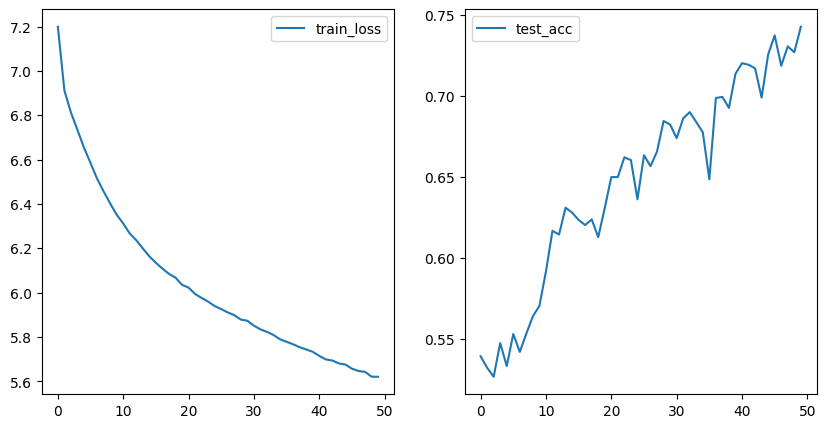

In [ ]:
import matplotlib.pyplot as plt

eps = range(len(train_loss))

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(eps, train_loss, label = 'train_loss')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(eps, test_acc, label = 'test_acc')
ax2.legend()
plt.show()

Train Loss는 지속적으로 감소하며, Test Accuracy는 꾸준히 증가하여 약 80%까지 도달합니다.
이는 모델이 안정적으로 학습되었고, 과적합 없이 일반화 성능이 향상되고 있음을 의미합니다.

In [ ]:
val_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
with torch.no_grad():
    for i, (inp, labels, mask) in enumerate(val_loader):
        inp = inp.long().to(device)
        labels = labels.to(device)
        mask = mask.to(device)
        mlm_logits, nsp_logits = model(inp, mask)
        cls = nsp_logits.argmax(dim=1)
        encode = inp.cpu().tolist()
        print(list(encode))
        print(f'입력: {sp.decode(list(encode))}')
        print(f'레이블: {labels}')
        print(f'예측: {cls}')
        if i > 10:
            break

[[1, 193, 305, 25, 1112, 176, 339, 953, 3, 2, 154, 1130, 8, 4, 709, 709, 2526, 5, 72, 783, 3, 3428, 99, 474, 4, 87, 70, 154, 6, 4, 3969, 13, 1696, 1745, 21, 1262, 3, 1295, 10, 968, 783, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
입력: ['은퇴 후의 삶이 참 걱정이 되네 ⁇  남편분이 든든하신가 봐요 ⁇  특별히 어떤 면에서 남편을 믿고 의지하시는지 여 ⁇ 봐도 될까요 ⁇ ']
레이블: tensor([0], device='cuda:0')
예측: tensor([1], device='cuda:0')
[[1, 372, 990, 7, 2999, 104, 128, 159, 97, 3, 1880, 8, 90, 202, 112, 3, 2, 464, 5, 150, 120, 2901, 186, 1714, 6, 147, 701, 155, 1745, 760, 783, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
입력: ['친구에게 사기를 당했는데 어떻게 해야 할지 모르겠어 ⁇  큰일이 날까 불안해 ⁇  장애가 있어서 친구들이 사용자님을 싫어한다고 생각하시는군요 ⁇ ']
레이블: tensor([0], device='cuda:0')
예측: tens

NSP 라벨에서 0과 1의 의미

- 0 = Not Matched Sentence (연속된 문장 아님)
- 1 = Matched Sentence (연속된 문장)



이 예시들을 보면 대부분 레이블과 예측이 일치해서 NSP 패턴을 꽤 잘 학습한 상태로 보입니다.

다만 마지막처럼 긍정·안정 감정이 섞인 문장은 0과 1을 헷갈려 하는 오분류가 남아 있어, 추가 데이터나 튜닝 여지가 있다는 정도로 해석하면 될 것 같아요.